## Chest Xray Detection for Covid 19 by Convulation Neural Network 

#### Importing libraries and essentials for the model

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPool2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
import pandas as pd
import numpy as np

##### Data Augmentation

Increasing the data by horizontal flip, shear range and rotation range to get the image classification better accuracy

In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255,horizontal_flip=True,
                                 shear_range=.2,rotation_range=.2)
test_datagen=ImageDataGenerator(rescale=1./255)


##### About Dataset

   1. The dataset consists of training data, validation data, and testing data.
   2. The training data consists of 5,216 chest x-ray images with 3,875 images shown to have pneumonia and 1,341 images shown to be normal.
   3. The validation data is relatively small with only 16 images with 8 cases of pneumonia and 8 normal cases.
   4. The testing data consists of 624 images split between 390 pneumonia cases and 234 normal cases.


**The target size will be (224,224), the class mode will be categorical and the batch size 15**

In [ ]:
training_set=train_datagen.flow_from_directory("/content/drive/MyDrive/chest_xray_dataset/train",
                                               target_size=(224,224),shuffle=True, class_mode="categorical",
                                               batch_size=15)
test_set=test_datagen.flow_from_directory("/content/drive/MyDrive/chest_xray_dataset/test",target_size=(224,224),
                                          shuffle=True,class_mode="categorical",batch_size=15)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
folder=glob("/content/drive/MyDrive/chest_xray_dataset/train/*")
len(folder)

2

#### Convolution Neural Network

Convolutional neural networks are composed of multiple layers of artificial neurons. Artificial neurons, a rough imitation of their biological counterparts, are mathematical functions that calculate the weighted sum of multiple inputs and outputs an activation value.

I have taken four convolution layers with activation funtion **relu** and two max pool layer after that I have connected the layer to fully connected layer with an activation funtion **softmax** 

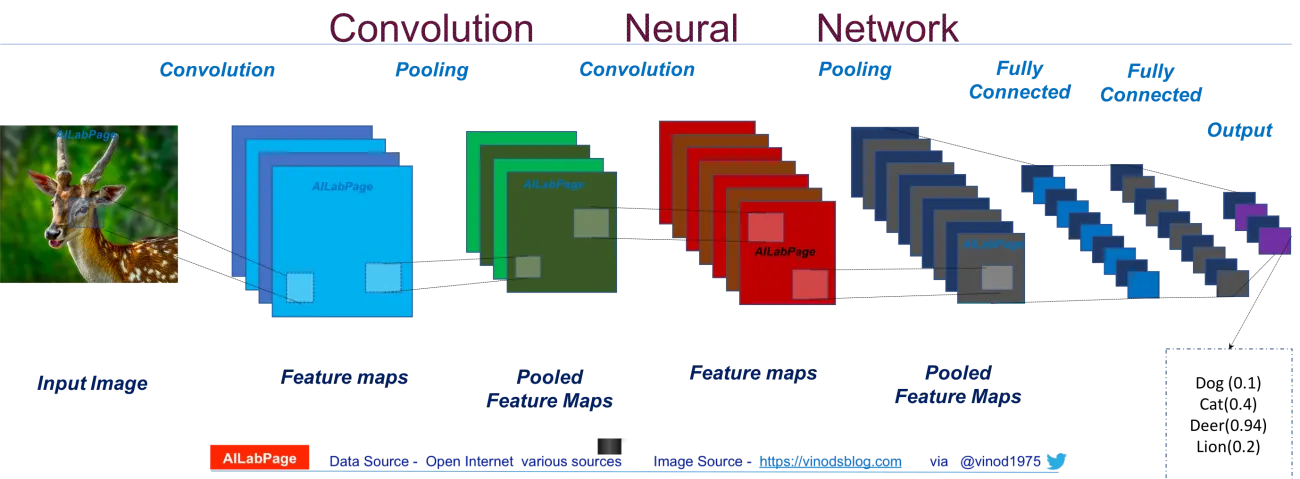

In [ ]:
def build_model(hp):
  cnn_model=keras.Sequential([
                              keras.layers.Conv2D(filters=hp.Int("Conv_1_filter", min_value=32,max_value=128,step=16),
                                                  activation="relu",kernel_size=hp.Choice("Conv_1_filter_size",values=[3,5]),
                                                  input_shape=[224,224,3]),
                              keras.layers.Conv2D(filters=hp.Int("Conv_2_filter",min_value=16,max_value=128,step=16),
                                                  activation="relu",kernel_size=hp.Choice("Conv_2_filter_size",values=[3,5]),
                                                  ),
                              keras.layers.MaxPool2D(pool_size=hp.Choice("Maxpool_1_poolsize",values=[2,3,5,7]),
                                                     ),
                              keras.layers.Conv2D(filters=hp.Int("Conv_3_filter",min_value=8,max_value=64,step=8),
                                                  activation="relu",kernel_size=hp.Choice("Conv_3_filter_size",values=[3,5]),
                                                ),
                              keras.layers.Conv2D(filters=hp.Int("Conv_4_filter",min_value=8,max_value=64,step=8),
                                                  activation="relu",kernel_size=hp.Choice("Conv_4_filter_size",values=[3,5]),
                                                  ),
                              keras.layers.MaxPool2D(pool_size=hp.Choice("Maxpool_2_poolsize",values=[2,3,5]),
                                                     ),
                              keras.layers.Flatten(),
                              keras.layers.Dense(units=hp.Int("Dense_1_units",min_value=32,max_value=128),activation="relu"),
                              keras.layers.Dense(units=hp.Int("Dense_2_units",min_value=32,max_value=128),activation="relu"),
                              keras.layers.Dense(units=len(folder),activation="softmax")
  ])
  cnn_model.compile(optimizer=keras.optimizers.Adam(hp.Choice("Learning_rate",values=[.01,.001,.0001])),
                    loss="categorical_crossentropy",metrics=["accuracy"])
  return cnn_model

#### Keras Tuner

It is a library that helps you pick the optimal set of hyperparameters for your TensorFlow program. The process of selecting the right set of hyperparameters for your machine learning (ML) application is called hyperparameter tuning or hypertuning.

In [ ]:
from kerastuner import RandomSearch

In [ ]:
hyper_cnn_model=RandomSearch(build_model,objective="accuracy",
                             max_trials=3,directory="output",project_name="Corona19")

**First we will max trail the training dataset to three times with a epochs of 10 then we will take the best model and train the rest of the epochs.**

In [ ]:
hyper_cnn_model.search(training_set,epochs=10)

Trial 3 Complete [00h 16m 54s]
accuracy: 0.9771856069564819

Best accuracy So Far: 0.9771856069564819
Total elapsed time: 01h 12m 36s
INFO:tensorflow:Oracle triggered exit


**It has been seen that after three max trail the accuracy is some what around 97%**

In [ ]:
best_model=hyper_cnn_model.get_best_models(num_models=1)[0]

**We will now take that best model and train the rest of the dataset**

In [ ]:
cnn=best_model.fit_generator(training_set,validation_data=test_set,initial_epoch=10,epochs=20,
validation_steps=len(test_set),steps_per_epoch=len(training_set))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 11/20
348/348 [==============================] - 255s 734ms/step - loss: 0.0504 - accuracy: 0.9816 - val_loss: 1.9305 - val_accuracy: 0.7099
Epoch 12/20
348/348 [==============================] - 107s 309ms/step - loss: 0.0479 - accuracy: 0.9810 - val_loss: 2.6915 - val_accuracy: 0.7308
Epoch 13/20
348/348 [==============================] - 108s 310ms/step - loss: 0.0447 - accuracy: 0.9862 - val_loss: 1.2483 - val_accuracy: 0.8045
Epoch 14/20
348/348 [==============================] - 108s 310ms/step - loss: 0.0459 - accuracy: 0.9841 - val_loss: 1.6561 - val_accuracy: 0.7324
Epoch 15/20
348/348 [==============================] - 108s 310ms/step - loss: 0.0307 - accuracy: 0.9883 - val_loss: 2.8851 - val_accuracy: 0.7260
Epoch 16/20
348/348 [==============================] - 109s 313ms/step - loss: 0.0372 - accuracy: 0.9873 - val_loss: 3.2645 - val_accuracy: 0.7035
Epoch 17/20
348/348 [==============================] - 107s 309ms/step - loss: 0.0356 - accuracy: 0.9877 - val_loss: 2

After training the model I have noticed that the model is **Overfiiting.**

**Overfitting means for training dataset the model perform good but for test dataset the model will not perform well.**  

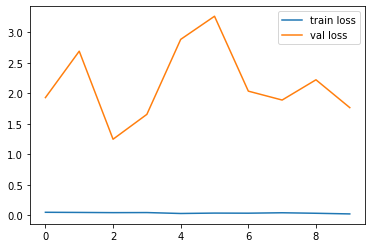

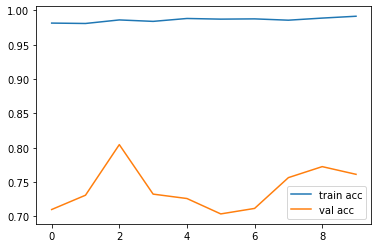

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
# plot the loss
plt.plot(cnn.history['loss'], label='train loss')
plt.plot(cnn.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(cnn.history['accuracy'], label='train acc')
plt.plot(cnn.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

##### Prediction

In [ ]:
y_pred_cnn=best_model.predict(test_set)

**The predicted output is a probability due to the activation funtion Softmax, it returns probability of the classes
We will now change the probability to discrete values**

In [ ]:
import numpy as np
y_pred_cnn=np.argmax(y_pred_cnn,axis=1)

**Saving the model**

In [ ]:
best_model.save("CNN_COVID.h5")

In [ ]:
from tensorflow.keras.models import load_model
model_cnn=load_model("CNN_COVID.h5")

**Testing the Model with validation dataset** 

Saving NORMAL2-IM-1442-0001.jpeg to NORMAL2-IM-1442-0001.jpeg
Covid_19 NEGATIVE


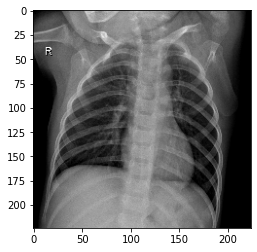

In [ ]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  # predict images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis =0)

  preds = model_cnn.predict(x)
  preds=np.argmax(preds, axis=1)
  if preds==0:
        preds="Covid_19 NEGATIVE"
  else:
        preds="COVID_19 POSITIVE"
  print(preds)
  plt.imshow(img)
